In [28]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Reshape, MultiHeadAttention, Lambda, Dense, concatenate, LayerNormalization
from tensorflow.keras.models import Model
import numpy as np
import math, time
import matplotlib.pyplot as plt

In [2]:
# MultiHeadAttention practice

In [3]:
"""
tensorflow.keras.layers.MultiHeadAttention
+ assert key.shape[0]==value.shape[0]
+ output.shape = query.shape if output_shape==None else (query.shape[0],output_shape:int)
+ attentionMask.shape = (query.shape[0],key.shape[0])
"""

attentionMask = np.triu( np.ones((4,9),dtype=np.float32), k=0) # mask all i-j>k element
# k=0:upper; k>0:strict upper; k<0: strict down # some paper k=0 some k=1

q = Input(shape=(4,3)) # NLP:sentence(time),word(feature) # CV:W*H,channel
k = Input(shape=(9,5))
v = Input(shape=(9,6))
x = MultiHeadAttention(num_heads=2, key_dim=7, output_shape=10)(q,v,k,attention_mask=attentionMask)

model = Model([q,k,v], x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 3)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 9, 6)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 9, 5)]       0                                            
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, 4, 10)        388         input_1[0][0]                    
                                                                 input_3[0][0]                

In [4]:
for i in range(len(model.weights)):
    print( i, model.weights[i].name, model.weights[i].shape )

0 multi_head_attention/query/kernel:0 (3, 2, 7)
1 multi_head_attention/query/bias:0 (2, 7)
2 multi_head_attention/key/kernel:0 (5, 2, 7)
3 multi_head_attention/key/bias:0 (2, 7)
4 multi_head_attention/value/kernel:0 (6, 2, 7)
5 multi_head_attention/value/bias:0 (2, 7)
6 multi_head_attention/attention_output/kernel:0 (2, 7, 10)
7 multi_head_attention/attention_output/bias:0 (10,)


In [5]:
3*2*7 + 2*7 + 5*2*7 + 2*7 + 6*2*7 + 2*7 + 14*10 + 10

388

In [6]:
# positional encoding practice

In [31]:
enc = np.zeros((784,64))
for i in range(784):
    for j in range(64):
        enc[i][j] = math.cos(i*1000**(-2*j/784)) if i%2 else math.sin(i*1000**(-2*j/784))

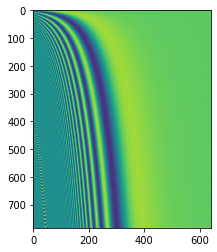

In [26]:
enc640 = np.zeros((784,640))
for i in range(784):
    for j in range(640):
        enc640[i][j] = math.cos(i*1000**(-2*j/784)) if i%2 else math.sin(i*1000**(-2*j/784))

plt.imshow(enc640)
plt.show()

In [27]:
# FFN with multiHeadAttention and positional encoding

In [68]:
s = 28 # image_size_side
attentionMask = np.triu( np.ones((s*s,s*s),dtype=np.float32), k=0) # mask all i-j>k element

q = Input(shape=(s*s,64)) # NLP:sentence(time),word(feature) # CV:W*H,channel
qe = Lambda(lambda data: data+enc)(q)
k = Input(shape=(s*s,64))
ke = Lambda(lambda data: data+enc)(k)
v = Input(shape=(s*s,64))
ve = Lambda(lambda data: data+enc)(v)

x = MultiHeadAttention(num_heads=32, key_dim=s*s, output_shape=None)(qe,ve,ke,attention_mask=attentionMask)

def ffnBlock(x):
    ffnList = []
    for i in range(s*s):
        ffn = Lambda(lambda data: data[:,i])(x)
        ffn = Dense(64)(ffn)
        ffnList.append(ffn)
    c = concatenate(ffnList, axis=0) # default axis=-1
    return c
    
x = ffnBlock(x)
x = LayerNormalization()(x) # default axis=-1

model = Model([q,k,v], x)
model.count_params()

9759424

In [70]:
s = time.time()
o = model.predict( [np.zeros((1,784,64)), np.zeros((1,784,64)), np.zeros((1,784,64))] )
print(time.time()-s, o.shape)

0.2997705936431885 (784, 64)
